In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')
from statsmodels.tsa.arima.model import ARIMA

In [15]:
# Load data
df = pd.read_csv('ADAUSDT.csv');
dfClose = df['Close'];
df1 = dfClose.iloc[::-1];
dfClose_reversed = df1;
df_close =[];
for val in df1:
    df_close.append(float(val))


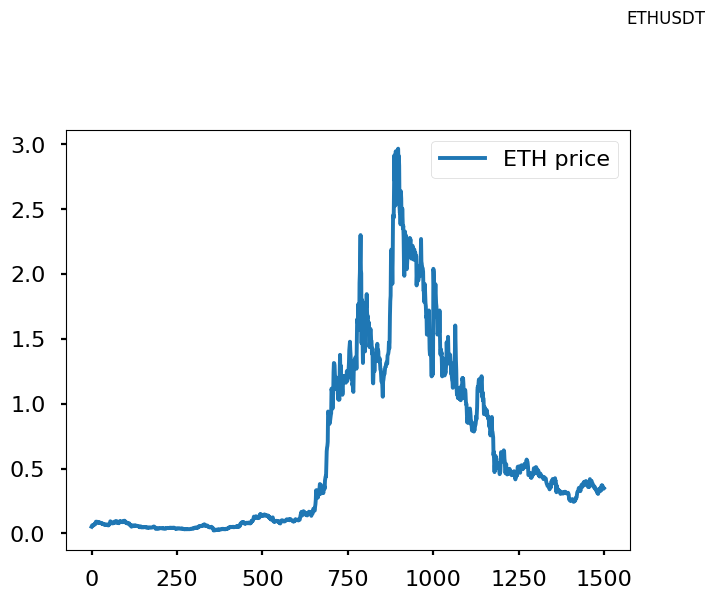

In [16]:
# PLOTS
fig = plt.figure(figsize=[16, 12])
plt.suptitle('ETHUSDT', fontsize=12)

plt.subplot(221)
plt.plot(df_close, '-', label='ETH price')
plt.legend()

# plt.tight_layout()
plt.show()

Để giảm biến động và làm ổn định phương sai, ta logarit hóa dữ liệu.

In [17]:
df_close_log = np.log(df_close)
print(df_close_log)

[-2.95651156 -2.84731227 -2.76462055 ... -1.03282455 -1.06421086
 -1.0555528 ]


Kiểm chứng ADF (Augmented Dickey-Fuller) với dữ liệu để kiểm tra tính dừng, nếu dữ liệu chưa dừng, ta sẽ dịch differencing lên, số lần dịch differencing lên là tham số I trong mô hình ARIMA

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

adf_test(df_close_log)

1. ADF :  -1.170694984430326
2. P-Value :  0.6860732803080708
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1495
5. Critical Values :
	 1% :  -3.434731647915545
	 5% :  -2.8634752174058944
	 10% :  -2.5678002869095424


Vì  p-value > 0.05 
Vậy, chuỗi trên không phải chuỗi dừng vì vượt ngưỡng, vì thế ta dịch chuỗi lên 1.

In [19]:
#convert list to DF
df_close_log = pd.DataFrame(df_close_log)

adf_test(df_close_log.diff().dropna());

1. ADF :  -18.41979434954769
2. P-Value :  2.1772510644034957e-30
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1495
5. Critical Values :
	 1% :  -3.434731647915545
	 5% :  -2.8634752174058944
	 10% :  -2.5678002869095424


Sau khi Diff 1 lần, ta thấy p-value < 0.05, nên chấp nhận và số lần Diff là tham số của I trong mô hình ARIMA(p,d,q) là 1

Xác định hệ số AR(p) - MA(q) bằng cách vẽ ACF và PACF

<Figure size 1000x1000 with 0 Axes>

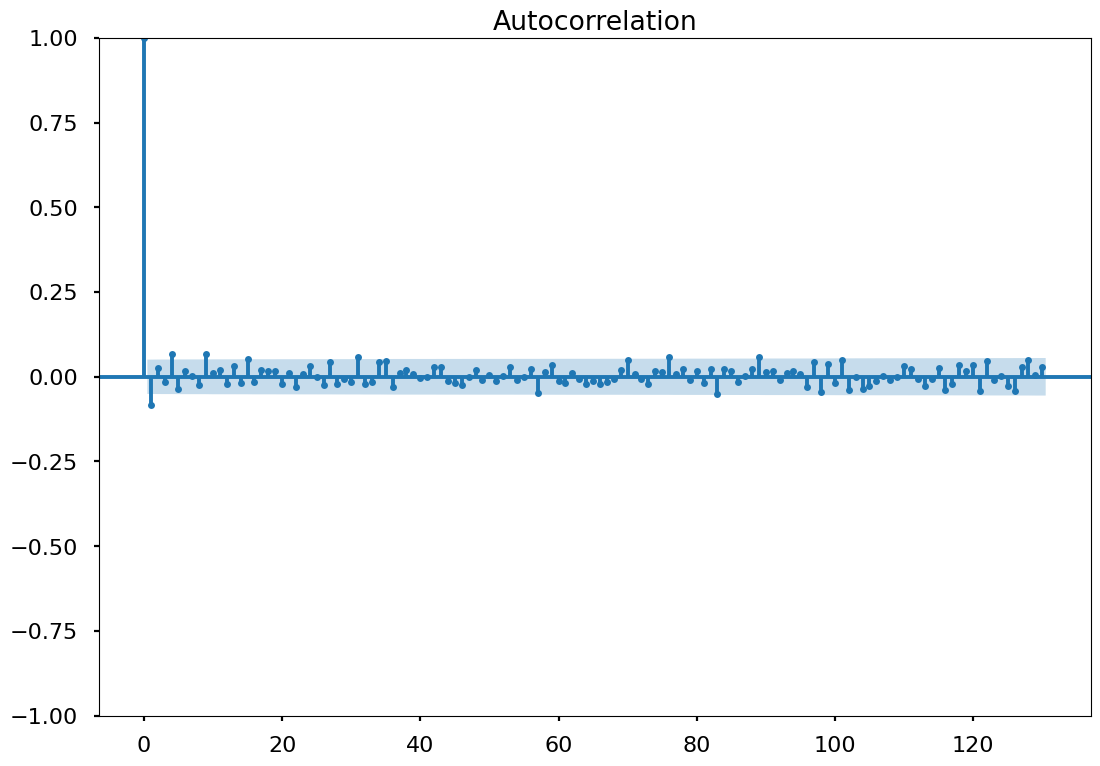

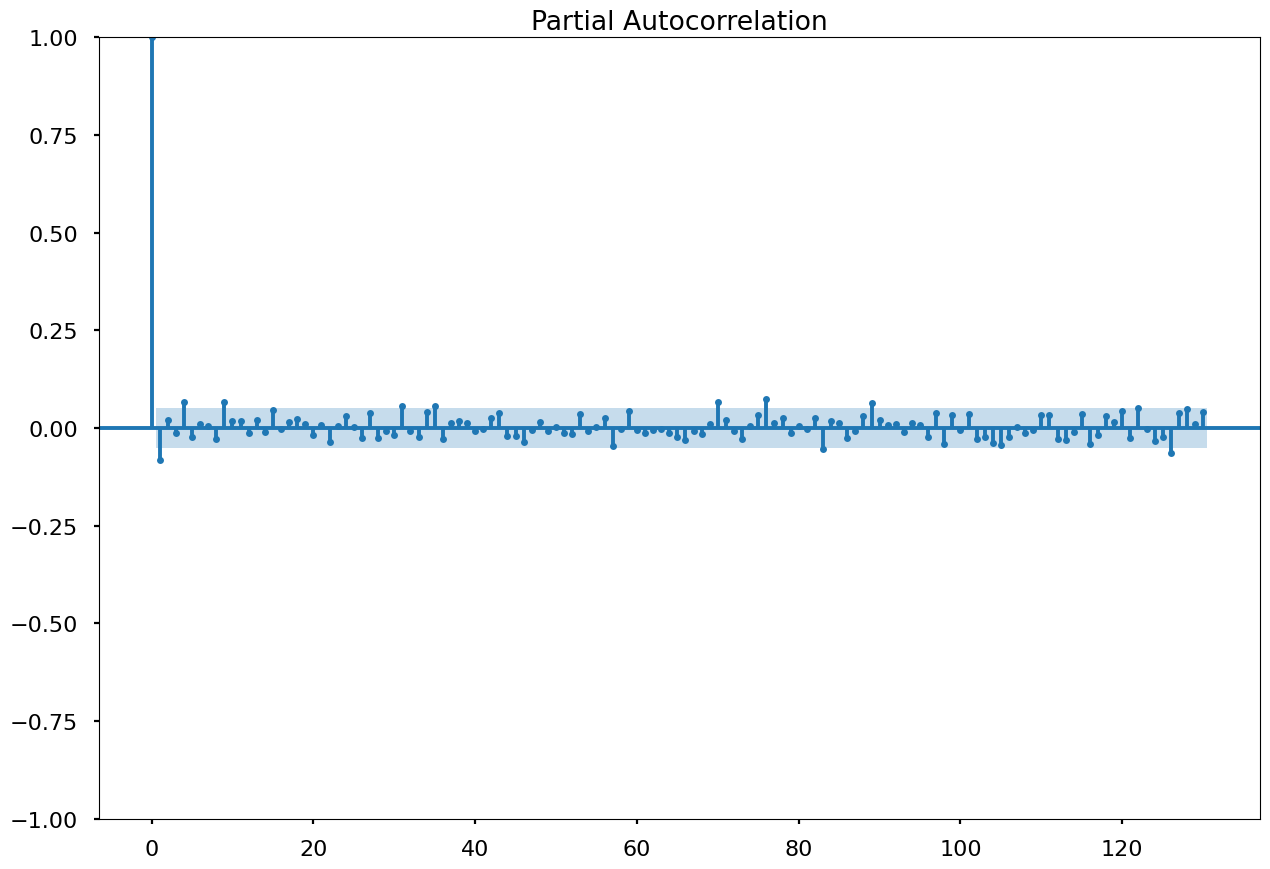

In [20]:
#Tính toán ACF và PACF 
plt.figure(figsize=[10, 10])

sm.graphics.tsa.plot_acf(df_close_log.diff().dropna(), lags=130)
plt.show();

sm.graphics.tsa.plot_pacf(df_close_log.diff().dropna(),lags=130);
plt.tight_layout();

plt.show();


- Giá trị p được xác định số lượng lags trong hàm PACF đầu tiên vượt ngưỡng tín hiệu
- Giá trị q được xác định bằng số lượng lags trong hàm ACF vượt quá ngưỡng tín hiệu của biểu đổ ACF

Vậy, giá trị p = 1
giá trị q = 3, trong ACF có nhiều giá trị vượt ngưỡng, nhưng ta không nên xét hết tất cả để tránh bị overfitting

Chia dataset thành 7 : 1 : 2 (train - validate - test)

In [25]:
train_size = int(len(df)*0.7);
val_size = int(len(df)*0.1);
test_size = int(len(df)*0.2);

df_train = dfClose_reversed.iloc[:train_size];
df_validate = dfClose_reversed.iloc[train_size:train_size+val_size];
df_test = dfClose_reversed.iloc[train_size+val_size:train_size+val_size+test_size];

#convert index
def convertIndex(df):
    data=[];
    for val in df:
        data.append(float(val));
    return pd.DataFrame(data);

df_train = convertIndex(df_train);
df_test = convertIndex(df_test);
df_validate = convertIndex(df_validate);

print(df_train);
print(df_test);
print(df_validate);



          0
0     0.052
1     0.058
2     0.063
3     0.062
4     0.059
...     ...
1045  1.332
1046  1.359
1047  1.308
1048  1.380
1049  1.377

[1050 rows x 1 columns]
         0
0    0.587
1    0.560
2    0.567
3    0.567
4    0.609
..     ...
295  0.360
296  0.351
297  0.356
298  0.345
299  0.348

[300 rows x 1 columns]
         0
0    1.319
1    1.309
2    1.230
3    1.280
4    1.210
..     ...
145  0.465
146  0.482
147  0.570
148  0.627
149  0.552

[150 rows x 1 columns]


In [22]:
def toArray(df):
    data=[];
    for val in df:
        data.append(float(val));
    return data;

In [23]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax                    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'mse':mse, 
            'corr':corr, 'minmax':minmax})


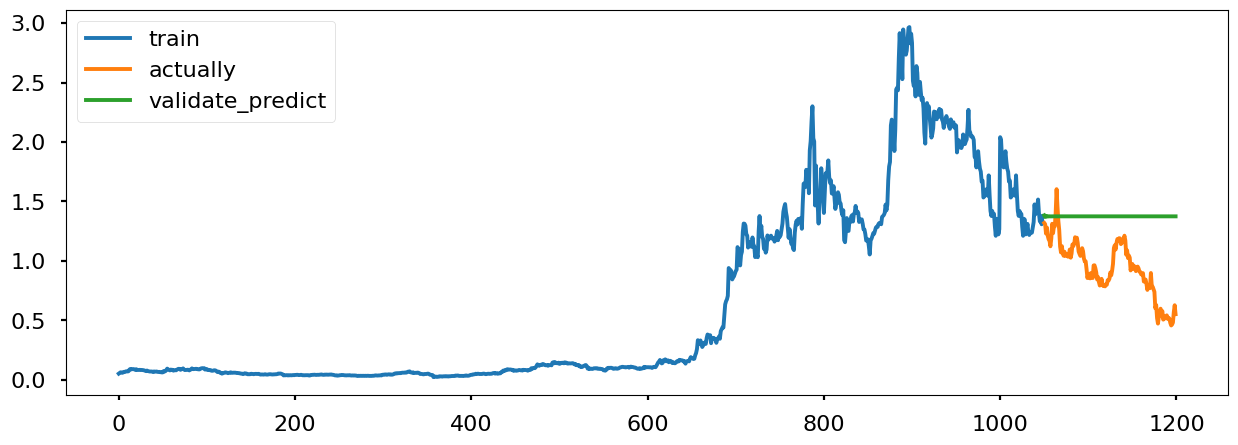

In [38]:

warnings.filterwarnings('ignore');
model = ARIMA(df_train, order=(1,1,3))
model_fit = model.fit();

#Make predictions for val model

forecast_val = model_fit.forecast(steps=val_size)

forecast_val = forecast_val.set_axis(pd.RangeIndex(start=train_size,stop=val_size+train_size));
df_val_indexed = df_validate.set_axis(pd.RangeIndex(start=train_size,stop=val_size+train_size));



#Visualize the predictions
plt.figure(figsize=(15,5));
plt.plot(df_train,label='train');
plt.plot(df_val_indexed,label='actually');
plt.plot(forecast_val,label='validate_predict');

plt.legend();
plt.show();

Kiểm chứng độ chính xác

In [65]:
forecast_val = forecast_val.set_axis(pd.RangeIndex(start=0,stop=val_size));
df_val_indexed = df_validate.set_axis(pd.RangeIndex(start=0,stop=val_size));

# print(forecast_val)
# print(np.array(df_val_indexed))
df_val_indexed_1dim = [];
for val in np.array(df_val_indexed):
    # print(val[0]);
    df_val_indexed_1dim.append(val[0])

print(df_val_indexed_1dim)

accuracy = forecast_accuracy(pd.Series(np.array((forecast_val))), pd.Series(np.array(df_val_indexed_1dim)));
print('RMSE: ',accuracy['rmse'])
print('MAPE: ',accuracy['mape'])

[1.319, 1.309, 1.23, 1.28, 1.21, 1.181, 1.17, 1.123, 1.187, 1.312, 1.233, 1.292, 1.291, 1.41, 1.603, 1.458, 1.337, 1.259, 1.12, 1.071, 1.124, 1.065, 1.043, 1.077, 1.042, 1.048, 1.059, 1.035, 1.051, 1.096, 1.027, 1.061, 1.138, 1.125, 1.143, 1.199, 1.176, 1.195, 1.15, 1.079, 1.059, 1.042, 1.049, 1.107, 1.082, 1.02, 0.995, 0.996, 0.931, 0.856, 0.888, 0.866, 0.853, 0.898, 0.887, 0.856, 0.962, 0.963, 0.939, 0.903, 0.844, 0.864, 0.823, 0.793, 0.802, 0.849, 0.807, 0.788, 0.789, 0.786, 0.802, 0.8, 0.838, 0.835, 0.851, 0.903, 0.879, 0.917, 0.975, 1.108, 1.131, 1.096, 1.152, 1.184, 1.17, 1.191, 1.189, 1.141, 1.165, 1.155, 1.186, 1.212, 1.171, 1.052, 1.089, 1.024, 1.045, 1.027, 0.92, 0.955, 0.974, 0.933, 0.956, 0.951, 0.914, 0.937, 0.952, 0.937, 0.91, 0.906, 0.886, 0.886, 0.897, 0.826, 0.84, 0.843, 0.805, 0.756, 0.789, 0.781, 0.771, 0.898, 0.788, 0.783, 0.76, 0.74, 0.602, 0.629, 0.519, 0.473, 0.529, 0.537, 0.598, 0.557, 0.578, 0.506, 0.533, 0.516, 0.529, 0.542, 0.513, 0.522, 0.515, 0.479, 0.457, 